In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
sns.set()


from copy import deepcopy
from collections import defaultdict

# Columns with categorical data that needs to be encoded
categorical_cols = ['serve', 'hitpoint', 'outside.sideline', 
                    'outside.baseline', 'same.side', 'server.is.impact.player', 'outcome', 
                    'gender' , 'previous.hitpoint']

# Columns in the Data That Should Be Scaled
scaled_data = ['rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net', 'player.impact.distance.from.center']

# Columns to be dropped
dropcols = ['id', 'train', 'gender', 'same.side', 'server.is.impact.player', 'outside.baseline', 
            'previous.hitpoint', 'hitpoint', 'rally', 'serve', 'outside.sideline', 'player.distance.from.center',
            'player.distance.from.each.other.length', 'player.distance.from.each.other.width',
           'player.impact.distance.from.center',
           'opponent.distance.from.center', 'player.from.net.penultimate', 'bw.player.distance.penultimate'
           ,'net.clearance.difference', 'depth']

# Load Data
raw_mens_train = pd.read_csv('tennis_data/mens_train_file.csv')
raw_mens_test = pd.read_csv("tennis_data/mens_test_file.csv")
raw_womens_train = pd.read_csv('tennis_data/womens_train_file.csv')
raw_womens_test = pd.read_csv("tennis_data/womens_test_file.csv")

# NO IMPACTS- gender, train, id rally
# LOW IMPACT- 'server.is.impact.player', 'previous.hitpoint', 'same.side',  'outside.baseline',
# MED IMPACT- 'previous.time.to.net', 'opponent.distance.from.center', 'opponent.depth',  'previous.depth',  
# 'previous.distance.from.sideline', 'previous.net.clearance', 'player.distance.from.center',  'player.depth',
# 'player.impact.distance.from.center', 'player.distance.travelled', 'distance.from.sideline',
# HIGH IMPACT- 'previous.speed', 'player.impact.depth', 'depth', 'speed'


# Feature Engineering

def feature_engineer(data):
    data['speed.difference'] = data['speed'] - data['previous.speed']
    data['net.clearance.difference'] = data['net.clearance'] - data['previous.net.clearance']
    data['true.distance.from.sideline'] = [dist if not boolean else (dist * -1) for dist, boolean in 
                                                 zip(data['distance.from.sideline'], 
                                                     data['outside.sideline'])]

    data['true.distance.from.baseline'] = [dist if not boolean else (dist * -1) for dist, boolean in 
                                                    zip(data['depth'], 
                                                    data['outside.baseline'])]

    # Opponent distance to net + player distance to net
    data['player.distance.from.each.other.length'] = data['player.depth'] + data['opponent.depth']

    # Opponent distance from center + player distance to center
    data['player.distance.from.each.other.width'] = [math.fabs(p_center - o_center)
                                                             if boolean 
                                                             else p_center + o_center
                                                             for p_center, o_center, boolean in 
                                                             zip(data['player.distance.from.center'], 
                                                                 data['opponent.distance.from.center'], 
                                                                 data['same.side'])]

    # Straight line distance between players
    data['bw.player.distance.penultimate'] = [math.hypot(length, width)
                                                 for length, width in 
                                                 zip(data['player.distance.from.each.other.length'], 
                                                     data['player.distance.from.each.other.width'])]

    # Distance penultimate shot was made from net- previous to net (s) * penultimate shot (m/s)
    data['player.from.net.penultimate'] = data['previous.speed'] * data['previous.time.to.net']
    return data
    
mens_train = feature_engineer(raw_mens_train)
mens_test = feature_engineer(raw_mens_test)

womens_train = feature_engineer(raw_womens_train)
womens_test = feature_engineer(raw_womens_test)


# Encode Categorical Data
def encode(train, test):
    # Retain All LabelEncoder as a dictionary
    d = defaultdict(LabelEncoder)
    # Encode all the columns
    train[categorical_cols] = train[categorical_cols].apply(lambda x: d[x.name].fit_transform(x))
#     print(train)
    test_ids = test['id']
    # Inverse the encoding
    # data.apply(lambda x: d[x.name].inverse_transform(x))
    
    # Using dictionary d to label future data
    temp = deepcopy(categorical_cols)
    temp.remove('outcome')
    e = deepcopy(d)
    del e['outcome']
    
    test[temp] = test[temp].apply(lambda x: e[x.name].transform(x))
    train = train.drop(dropcols, axis=1)
    test = test.drop(dropcols + ['outcome'], axis=1)
    return train, test, test_ids, d
    

mens_train, mens_test, mens_test_ids , mens_d = encode(mens_train, mens_test)
womens_train, womens_test, womens_test_ids , womens_d = encode(womens_train, womens_test)


Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
mens_train_X = mens_train.loc[:, mens_train.columns != 'outcome']
mens_train_y = mens_train['outcome']

mens_train_X, val_train_X, mens_train_y, val_train_y = train_test_split(mens_train_X, mens_train_y, test_size=0.2)
mens_train_X.shape

(4000, 25)

In [6]:
X_train_np = mens_train_X.values.reshape((-1, 25))
Y_train_np = mens_train_y.reshape((-1,1))
X_val_np = val_train_X.values.reshape((-1, 25))
Y_val_np = val_train_y.values.reshape((-1,1))

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 161us/step - loss: 1.0013 - acc: 0.4825 - val_loss: 0.9060 - val_acc: 0.6270
Epoch 2/100
4000/4000 [==============================] - 0s 73us/step - loss: 0.9148 - acc: 0.5550 - val_loss: 0.8456 - val_acc: 0.6390
Epoch 3/100
4000/4000 [==============================] - 0s 75us/step - loss: 0.8774 - acc: 0.5807 - val_loss: 0.8322 - val_acc: 0.6450
Epoch 4/100
4000/4000 [==============================] - 0s 66us/step - loss: 0.8482 - acc: 0.5907 - val_loss: 0.7911 - val_acc: 0.6710
Epoch 5/100
4000/4000 [==============================] - 0s 66us/step - loss: 0.8272 - acc: 0.6172 - val_loss: 0.7847 - val_acc: 0.6690
Epoch 6/100
4000/4000 [==============================] - 0s 68us/step - loss: 0.8298 - acc: 0.6162 - val_loss: 0.7617 - val_acc: 0.6770
Epoch 7/100
4000/4000 [==============================] - 0s 82us/step - loss: 0.8218 - acc: 0.6185 - val_loss: 0.7644 - val_acc: 0.6800

4000/4000 [==============================] - 0s 80us/step - loss: 0.6575 - acc: 0.7053 - val_loss: 0.5850 - val_acc: 0.7530
Epoch 61/100
4000/4000 [==============================] - 0s 81us/step - loss: 0.6696 - acc: 0.6925 - val_loss: 0.5988 - val_acc: 0.7360
Epoch 62/100
4000/4000 [==============================] - 0s 67us/step - loss: 0.6651 - acc: 0.7007 - val_loss: 0.6242 - val_acc: 0.7160
Epoch 63/100
4000/4000 [==============================] - 0s 73us/step - loss: 0.6578 - acc: 0.7075 - val_loss: 0.6442 - val_acc: 0.7060
Epoch 64/100
4000/4000 [==============================] - 0s 83us/step - loss: 0.6656 - acc: 0.7023 - val_loss: 0.6217 - val_acc: 0.7230
Epoch 65/100
4000/4000 [==============================] - 0s 59us/step - loss: 0.6639 - acc: 0.7043 - val_loss: 0.5966 - val_acc: 0.7450
Epoch 66/100
4000/4000 [==============================] - 0s 66us/step - loss: 0.6612 - acc: 0.7070 - val_loss: 0.6241 - val_acc: 0.7260
Epoch 67/100
4000/4000 [==============================

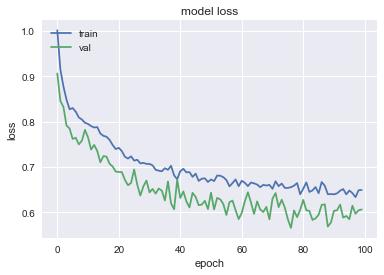

In [8]:
model = Sequential()
model.add(Dense(15, input_dim=25, activation='relu', kernel_initializer='random_uniform'))
model.add(Dropout(0.4))
model.add(Dense(15, input_dim=25, activation='relu', kernel_initializer='lecun_uniform'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.add(Dense(3, activation='softmax', kernel_initializer='lecun_uniform'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X_train_np, Y_train_np, epochs=100, batch_size=32, validation_data=(X_val_np, Y_val_np))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])  
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(model, mens_train_X, mens_train_y,cv=8)
confusion_matrix(mens_train_y,y_pred)

TypeError: Cannot clone object '<keras.models.Sequential object at 0x1a1d970160>' (type <class 'keras.models.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.